# Using numerical and categorical variables together

In the previous notebooks, we showed the required preprocessing to apply
when dealing with numerical and categorical variables. However, we decoupled
the process to treat each type individually. In this notebook, we will show
how to combine these preprocessing steps.

We will first load the entire adult census dataset.

In [ ]:
import pandas as pd

adult_census = pd.read_csv("../input/us-1994-census/census.csv")
# drop the duplicated column `"education-num"` as stated in the first notebook
#adult_census = adult_census.drop(columns="education-num")

target_name = "over50k"
target = adult_census[target_name]

data = adult_census.drop(columns=[target_name])

In [ ]:
data['nativecountry'].value_counts()

## Selection based on data types

We will separate categorical and numerical variables using their data
types to identify them, as we saw previously that `object` corresponds
to categorical columns (strings). We make use of `make_column_selector`
helper to select the corresponding columns.

In [ ]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

```{caution}
Here, we know that `object` data type is used to represent strings and thus
categorical features. Be aware that this is not always the case. Sometimes
`object` data type could contain other type of information (e.g. dates that
were not parsed) and you should manually introspect the content of your
dataframe to not wrongly use `make_column_selector`.
```

## Dispatch columns to a specific processor

In the previous sections, we saw that we need to treat data differently
depending on their nature (i.e. numerical or categorical).

Scikit-learn provides a `ColumnTransformer` class which will send specific
columns to a specific transformer, making it easy to fit a single predictive
model on a dataset that combines both kinds of variables together
(heterogeneously typed tabular data).

We first define the columns depending on their data type:

* **one-hot encoding** will be applied to categorical columns. Besides, we
  use `handle_unknown="ignore"` to solve the potential issues due to rare
  categories.
* **numerical scaling** numerical features which will be standardized.

Now, we create our `ColumnTransfomer` by specifying three values:
the preprocessor name, the transformer, and the columns.
First, let's create the preprocessors for the numerical and categorical
parts.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

Now, we create the transformer and associate each of these preprocessors
with their respective columns.

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])

We can take a minute to represent graphically the structure of a
`ColumnTransformer`:

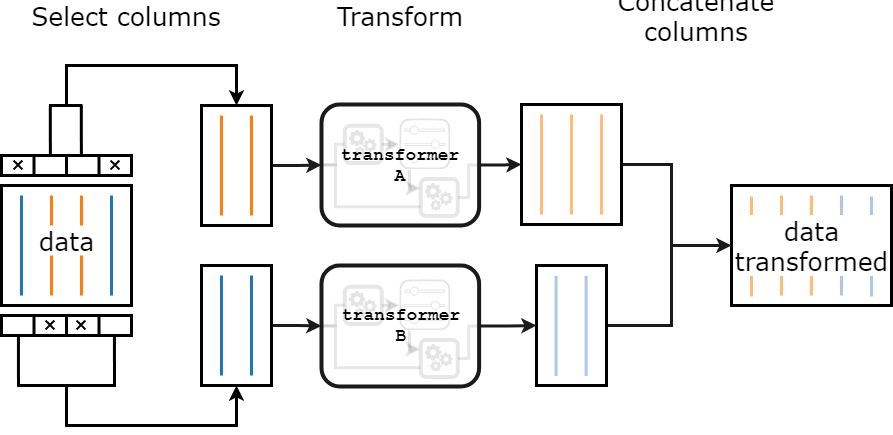
A `ColumnTransformer` does the following:

* It **splits the columns** of the original dataset based on the column names
  or indices provided. We will obtain as many subsets as the number of
  transformers passed into the `ColumnTransformer`.
* It **transforms each subsets**. A specific transformer is applied to
  each subset: it will internally call `fit_transform` or `transform`. The
  output of this step is a set of transformed datasets.
* It then **concatenates the transformed datasets** into a single dataset.

The important thing is that `ColumnTransformer` is like any other
scikit-learn transformer. In particular it can be combined with a classifier
in a `Pipeline`:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))

### We can display an interactive diagram with the following command:

In [ ]:
from sklearn import set_config
set_config(display='diagram')
model

The final model is more complex than the previous models but still follows
the same API (the same set of methods that can be called by the user):

- the `fit` method is called to preprocess the data and then train the
  classifier of the preprocessed data;
- the `predict` method makes predictions on new data;
- the `score` method is used to predict on the test data and compare the
  predictions to the expected test labels to compute the accuracy.

Let's start by splitting our data into train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)


```{caution}
Be aware that we use `train_test_split` here for didactic purposes, to show
the scikit-learn API.
```

Now, we can train the model on the train set.

In [ ]:
_ = model.fit(data_train, target_train)

Then, we can send the raw dataset straight to the pipeline. Indeed, we do not
need to make any manual preprocessing (calling the `transform` or
`fit_transform` methods) as it will be handled when calling the `predict`
method. As an example, we predict on the five first samples from the test
set.

In [ ]:
model.predict(data_test)[:5]

In [ ]:
target_test[:5]

To get directly the accuracy score, we need to call the `score` method. Let's
compute the accuracy score on the entire test set.

In [ ]:
model.score(data_test, target_test)

## Evaluation of the model with cross-validation

As previously stated, a predictive model should be evaluated by
cross-validation. Our model is usable with the cross-validation tools of
scikit-learn as any other predictors:

In [ ]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target, cv=5)
cv_results

In [ ]:
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The compound model has a higher predictive accuracy than the two models that
used numerical and categorical variables in isolation.

## Fitting a more powerful model

**Linear models** are nice because they are usually cheap to train,
**small** to deploy, **fast** to predict and give a **good baseline**.

However, it is often useful to check whether more complex models such as an
ensemble of decision trees can lead to higher predictive performance. In this
section we will use such a model called **gradient-boosting trees** and
evaluate its generalization performance. More precisely, the scikit-learn model
we will use is called `HistGradientBoostingClassifier`. Note that boosting
models will be covered in more detail in a future module.

For tree-based models, the handling of numerical and categorical variables is
simpler than for linear models:
* we do **not need to scale the numerical features**
* using an **ordinal encoding for the categorical variables** is fine even if
  the encoding results in an arbitrary ordering

Therefore, for `HistGradientBoostingClassifier`, the preprocessing pipeline
is slightly simpler than the one we saw earlier for the `LogisticRegression`:

In [ ]:
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingClassifier (make sure to use sparse = False on the OneHotEncoder)
#from sklearn.preprocessing import OrdinalEncoder #Ordinal encoder doesn not handle
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import  RandomForestClassifier
from lightgbm import LGBMClassifier



#categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
#                                          unknown_value=-1)

#preprocessor = ColumnTransformer([
#    ('categorical', categorical_preprocessor, categorical_columns)],
 #   remainder="passthrough")
    
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse = False)

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns)])  

model = make_pipeline(preprocessor,  GradientBoostingClassifier())

Now that we created our model, we can check its generalization performance.

In [ ]:
%%time
_ = model.fit(data_train, target_train)

In [ ]:
model.score(data_test, target_test)


We can observe that we get significantly higher accuracies with the Gradient
Boosting model. This is often what we observe whenever the dataset has a
large number of samples and limited number of informative features (e.g. less
than 1000) with a mix of numerical and categorical variables.

This explains why Gradient Boosted Machines are very popular among
datascience practitioners who work with tabular data.

In this notebook we:

* used a `ColumnTransformer` to apply different preprocessing for
  categorical and numerical variables;
* used a pipeline to chain the `ColumnTransformer` preprocessing and
  logistic regression fitting;
* saw that **gradient boosting methods** can outperform **linear
  models**.